# Chapter 7 - Ensemble Learning and Random Forests

##Exercises Questions

1. If you have trained five different models on the exact same training data, and they all achieve 95% precision, is there any chance that you can combine these models to get better results? If so, how? If not, why?
- Ya, kita bisa mendapatkan hasil yang lebih baik dengan menggabungkan model-model tersebut menggunakan ensemble method seperti voting atau stacking. Ini karena setiap model mungkin memiliki kekuatan yang berbeda dalam menangkap pola data.

2. What is the difference between hard and soft voting classifiers?
- Hard voting menggunakan majority vote dari prediksi kelas, sedangkan soft voting menggunakan rata-rata probabilitas prediksi dari setiap model.

3. Is it possible to speed up training of a bagging ensemble by distributing it across multiple servers? What about pasting ensembles, boosting ensembles, Random Forests, or stacking ensembles?
- Ya, bagging dan pasting bisa di-distribute karena model-modelnya independent. Random Forests juga bisa karena merupakan kasus khusus dari bagging. Boosting dan stacking lebih sulit karena model-modelnya sequential.

4. What is the benefit of out-of-bag evaluation?
- Kita bisa mendapatkan estimasi performa model tanpa perlu validation set terpisah, karena setiap instance yang tidak digunakan dalam training bisa digunakan untuk evaluasi.

5. What makes Extra-Trees more random than regular Random Forests? How can this extra randomness help? Are Extra-Trees slower or faster than regular Random Forests?
- Extra-Trees lebih random karena menggunakan threshold acak untuk split. Ini membantu mengurangi variance dan overfitting. Extra-Trees lebih cepat karena tidak perlu mencari threshold optimal.

6. If your AdaBoost ensemble underfits the training data, which hyperparameters should you tweak and how?
- Tingkatkan n_estimators atau kurangi learning_rate untuk membuat model lebih kompleks.

7. If your Gradient Boosting ensemble overfits the training set, should you increase or decrease the learning rate?
- Kurangi learning rate untuk mengurangi overfitting.

In [161]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [162]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

In [163]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [164]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [165]:
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

,estimators,"[('lr', ...), ('rf', ...), ...]"
,voting,'hard'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True


In [166]:
from sklearn.metrics import accuracy_score

In [167]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.896


### Bagging and Pasting

In [168]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [169]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [170]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, title):
    h = 0.02
    
    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)
    
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, alpha=0.6, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.xlabel('X₁')
    plt.ylabel('X₂')
    
    return scatter


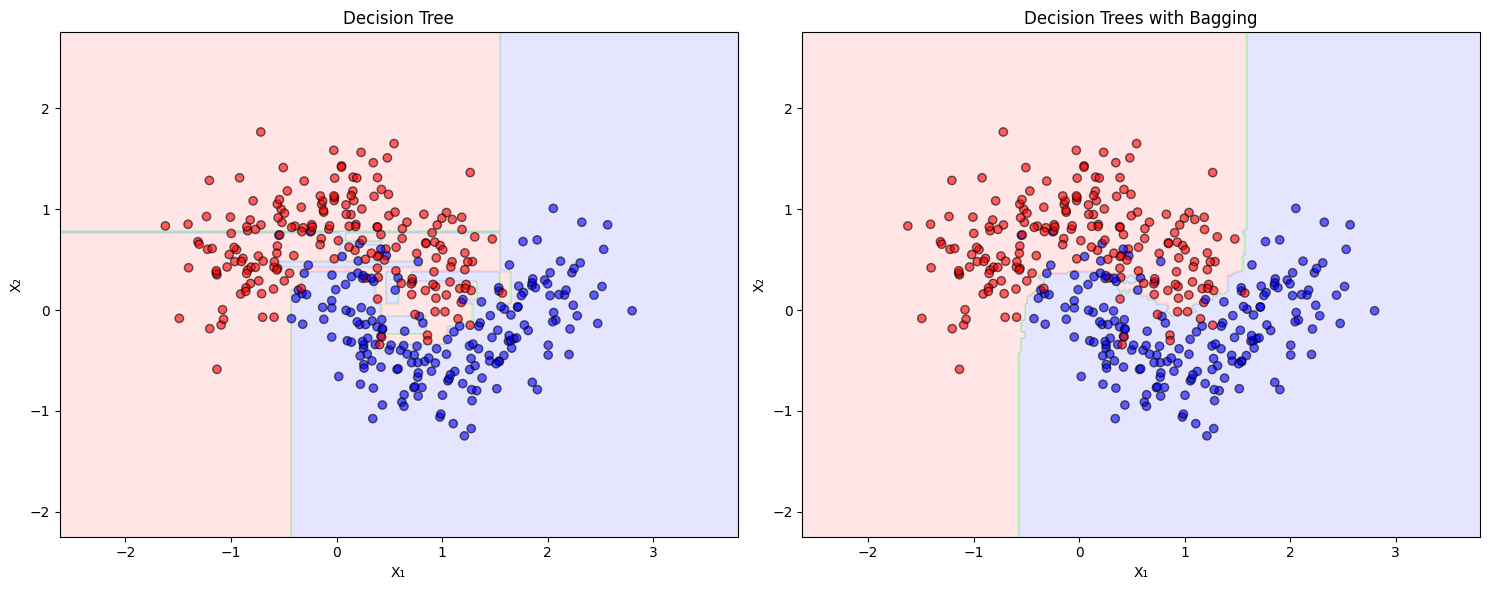

In [171]:
single_tree = DecisionTreeClassifier(random_state=42)
single_tree.fit(X_train, y_train)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

plt.sca(ax1)
plot_decision_boundary(single_tree, X_train, y_train, 'Decision Tree')

plt.sca(ax2)
plot_decision_boundary(bag_clf, X_train, y_train, 'Decision Trees with Bagging')

plt.tight_layout()
plt.show()


### Out-of-Bag Evaluation

In [172]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)

In [173]:
bag_clf.fit(X_train, y_train)
print(bag_clf.oob_score_)

0.8986666666666666


In [174]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

In [175]:
bag_clf.oob_decision_function_

array([[0.37634409, 0.62365591],
       [0.35672515, 0.64327485],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.05847953, 0.94152047],
       [0.39893617, 0.60106383],
       [0.01123596, 0.98876404],
       [0.99428571, 0.00571429],
       [0.98857143, 0.01142857],
       [0.77948718, 0.22051282],
       [0.        , 1.        ],
       [0.80319149, 0.19680851],
       [0.82513661, 0.17486339],
       [0.96875   , 0.03125   ],
       [0.05084746, 0.94915254],
       [0.        , 1.        ],
       [0.98901099, 0.01098901],
       [0.93406593, 0.06593407],
       [0.99438202, 0.00561798],
       [0.00520833, 0.99479167],
       [0.31904762, 0.68095238],
       [0.9       , 0.1       ],
       [1.        , 0.        ],
       [0.97752809, 0.02247191],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.63902439, 0.36097561],
       [0.

### Random Forest

In [176]:
from sklearn.ensemble import RandomForestClassifier

In [177]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [178]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

In [179]:
print("Random Forest accuracy:", accuracy_score(y_test, y_pred_rf))
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
print("Bagging Classifier accuracy:", accuracy_score(y_test, y_pred_bag))


Random Forest accuracy: 0.92
Bagging Classifier accuracy: 0.912


### Feature Importance

In [180]:
from sklearn.datasets import load_iris
iris = load_iris()

In [181]:
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [182]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,16
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [183]:
for name, score in zip(iris.feature_names, rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.08604252027855186
sepal width (cm) 0.021315435131348794
petal length (cm) 0.4516843502683282
petal width (cm) 0.4409576943217712


### Boosting

In [184]:
from sklearn.ensemble import AdaBoostClassifier

In [185]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME", learning_rate=0.5)
ada_clf.fit(X_train, y_train)

c:\Users\USER\Documents\SchoolWork\College\8th\ML\ml-enrichment-repo-ray\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


,estimator,DecisionTreeC...r(max_depth=1)
,n_estimators,200
,learning_rate,0.5
,algorithm,'SAMME'
,random_state,None
,criterion,'gini'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


### Gradient Boosting

In [186]:
from sklearn.tree import DecisionTreeRegressor

In [187]:
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

,criterion,'squared_error'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [188]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

,criterion,'squared_error'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [189]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

,criterion,'squared_error'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [190]:
y_pred = sum(tree.predict(X) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [191]:
from sklearn.ensemble import GradientBoostingRegressor

In [192]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

,loss,'squared_error'
,learning_rate,1.0
,n_estimators,3
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,2
,min_impurity_decrease,0.0
,init,None


In [193]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train, X_val, y_train, y_val = train_test_split(X, y)
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)
errors = [mean_squared_error(y_val, y_pred)
    for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1
gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,np.int64(93)
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,2
,min_impurity_decrease,0.0
,init,None


In [194]:
y_pred = gbrt.predict(X_val)

In [195]:
val_error = mean_squared_error(y_val, y_pred)
print(f"Validation MSE: {val_error}")

Validation MSE: 0.07838424334880044


In [196]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)
min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break

In [197]:
import xgboost

In [198]:
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [199]:
val_error = mean_squared_error(y_val, y_pred)
print(f"Validation MSE: {val_error}")


Validation MSE: 0.10504323989152908
